In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from scipy.signal import find_peaks

2024-01-13 10:45:43.202837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 10:45:43.238240: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 10:45:43.437084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 10:45:43.437185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 10:45:43.465228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


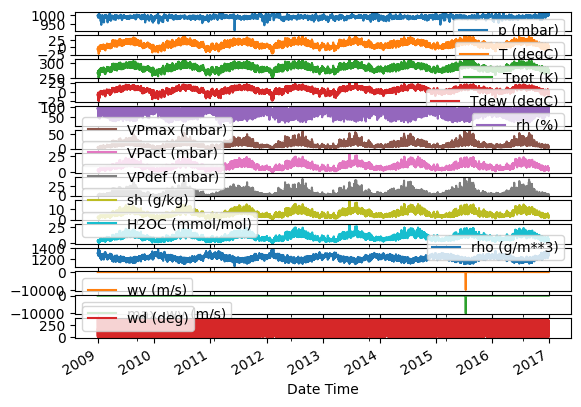

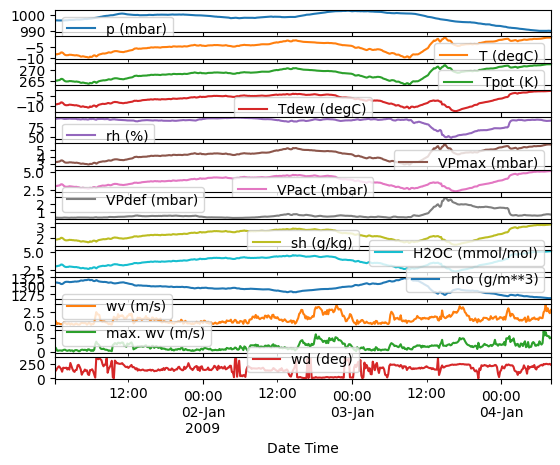

In [3]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

cols = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)']

plot_features = df[cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [4]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [5]:
wv = df['wv (m/s)']
wv_max = df['max. wv (m/s)']
bad_wv = wv == -9999.0
bad_wv_max = wv_max == -9999.0
wv[bad_wv] = 0.0
wv_max[bad_wv_max] = 0.0
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'wd (deg)')

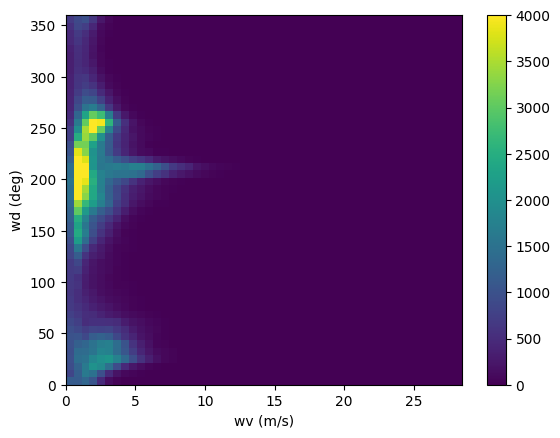

In [6]:
plt.hist2d(df['wv (m/s)'], df['wd (deg)'], bins=(50,50), vmax=4000)
plt.colorbar()
plt.xlabel('wv (m/s)')
plt.ylabel('wd (deg)')

## Convert wind direction and velocity to windvectors
$W_x = cos(d) \cdot v$
$W_y = sin(d) \cdot v$

Text(0, 0.5, 'y m/s')

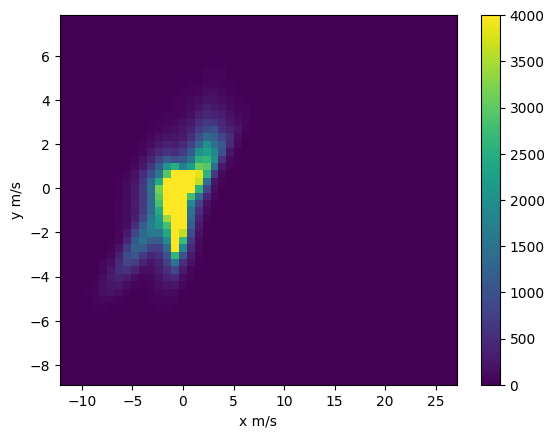

In [7]:
wv = df['wv (m/s)']
wd = df['wd (deg)'] * np.pi / 180.  # convert to radians
df['Wx'] = np.cos(wd) * wv
df['Wy'] = np.sin(wd) * wv

plt.hist2d(df['Wx'], df['Wy'], bins=(50,50), vmax = 4000)
plt.colorbar()
plt.xlabel('x m/s')
plt.ylabel('y m/s')

In [8]:
timestamp = date_time.map(pd.Timestamp.timestamp)

[1997489.2   445689.12]
important frequencies: [   8 2921]


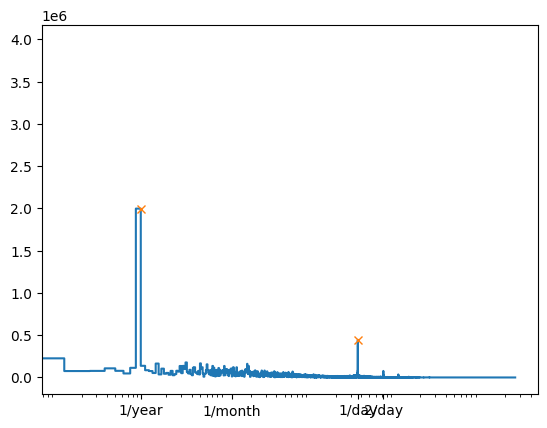

In [9]:
# check for important frequencies via fft
fft_temp = tf.signal.rfft(df['T (degC)'])
abs_fft_temp = np.array(abs(fft_temp))
n_freq = np.arange(0, len(fft_temp))
n_samples = len(df['T (degC)'])
hours = n_samples / 6
hours_per_year = 24 * 365.2524
f_per_year = n_freq / (hours / hours_per_year)
plt.xscale('log')

peaks, _ = find_peaks(abs_fft_temp, prominence=400000., distance=100)
peak_y = abs_fft_temp[peaks]
print(peak_y)
plt.step(f_per_year, abs_fft_temp)
plt.plot(peaks/ (hours / hours_per_year), peak_y, 'x')
plt.xticks([1, 12, 365.2524, 365.252 * 2], ['1/year', '1/month', '1/day', '2/day'])
print(f"important frequencies: {peaks}")

Text(0, 0.5, 'Time Signal')

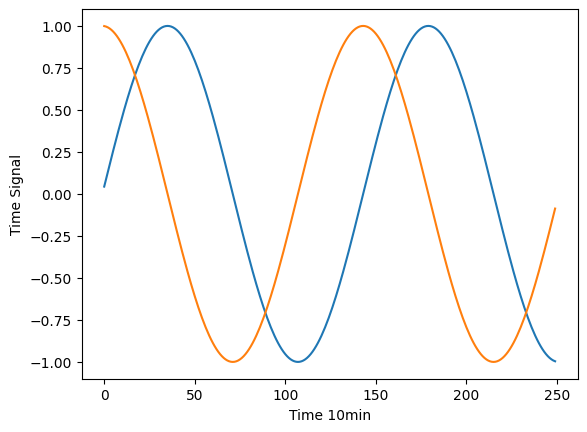

In [10]:
day = 24 * 60 * 60
year = 365.2425 * day
df['day sin'] = np.sin(timestamp * (2 * np.pi / day))
df['day cos'] = np.cos(timestamp * (2 * np.pi / day))
df['year sin'] = np.sin(timestamp * (2 * np.pi / year))
df['year cos'] = np.cos(timestamp * (2 * np.pi / year))

plt.plot(np.array(df['day sin'])[:250])
plt.plot(np.array(df['day cos'])[:250])
plt.xlabel('Time 10min')
plt.ylabel('Time Signal')

Text(0, 0.5, 'Time signal')

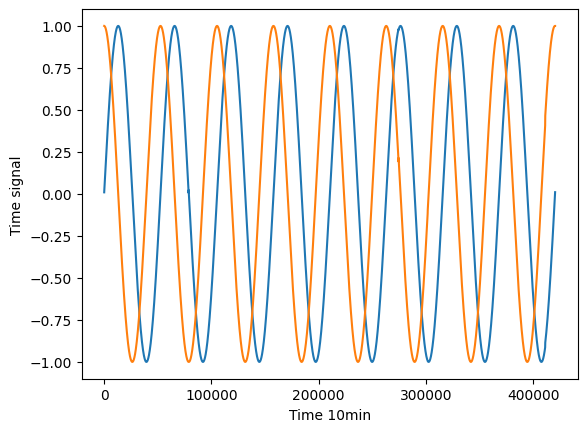

In [12]:
plt.plot(df['year sin'])
plt.plot(df['year cos'])
plt.xlabel('Time 10min')
plt.ylabel('Time signal')
# 8 years recording

In [13]:
# prepare trainingsdtata
# split (70, 20, 10)
# dont mix, since it's timeseries data

col_idx = { name: i for i, name in enumerate(df.columns)}
print(col_idx)

n = len(df)
train_df = df[0:int(.7 * n)]
val_df = df[int(.7*n):int(.9*n)]
test_df = df[int(.9*n):]

n_features = df.shape[1]

print(f"{n} samples in dataset:")
print(f"    {len(train_df)} in trainingset")
print(f"    {len(val_df)} in validationset")
print(f"    {len(test_df)} in testset")
print(f"{n_features} per sample")

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'wv (m/s)': 11, 'max. wv (m/s)': 12, 'wd (deg)': 13, 'Wx': 14, 'Wy': 15, 'day sin': 16, 'day cos': 17, 'year sin': 18, 'year cos': 19}
420551 samples in dataset:
    294385 in trainingset
    84110 in validationset
    42056 in testset
20 per sample


/tmp/ipykernel_3508/4096034524.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.keys(), rotation=90)


[Text(0, 0, 'p (mbar)'),
 Text(1, 0, 'T (degC)'),
 Text(2, 0, 'Tpot (K)'),
 Text(3, 0, 'Tdew (degC)'),
 Text(4, 0, 'rh (%)'),
 Text(5, 0, 'VPmax (mbar)'),
 Text(6, 0, 'VPact (mbar)'),
 Text(7, 0, 'VPdef (mbar)'),
 Text(8, 0, 'sh (g/kg)'),
 Text(9, 0, 'H2OC (mmol/mol)'),
 Text(10, 0, 'rho (g/m**3)'),
 Text(11, 0, 'wv (m/s)'),
 Text(12, 0, 'max. wv (m/s)'),
 Text(13, 0, 'wd (deg)'),
 Text(14, 0, 'Wx'),
 Text(15, 0, 'Wy'),
 Text(16, 0, 'day sin'),
 Text(17, 0, 'day cos'),
 Text(18, 0, 'year sin'),
 Text(19, 0, 'year cos')]

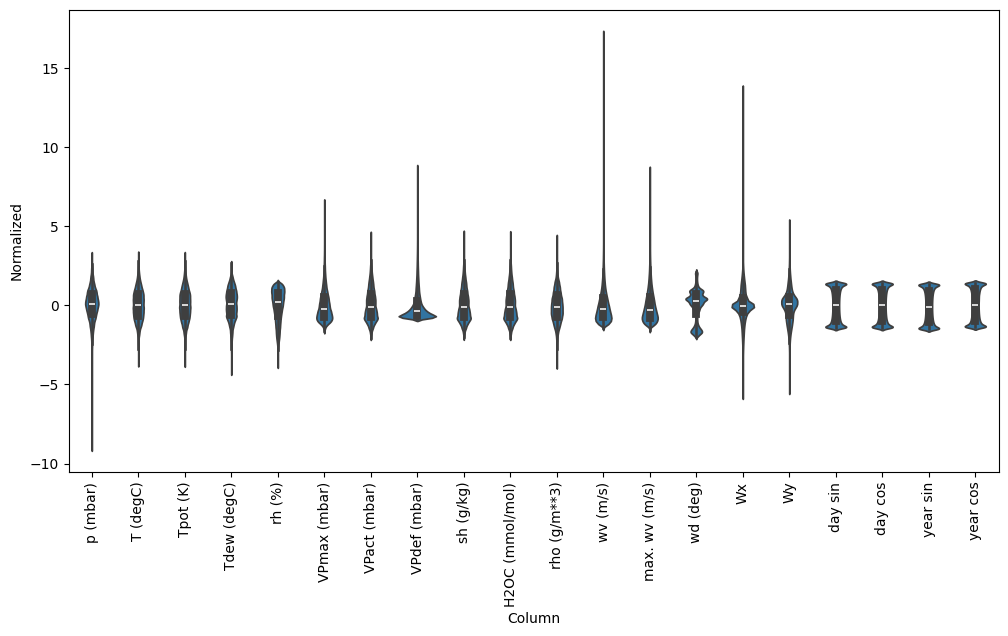

In [15]:
# normalize the data
train_std = train_df.std()
train_mean = train_df.mean() 

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_normalized = (df - train_mean) / train_std
df_normalized = df_normalized.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_normalized)
ax.set_xticklabels(df.keys(), rotation=90)

In [16]:
df_normalized

,Column,Normalized
0,p (mbar),0.947798
1,p (mbar),0.953824
2,p (mbar),0.949003
3,p (mbar),0.946592
4,p (mbar),0.946592
...,...,...
8411015,year cos,1.428444
8411016,year cos,1.428443
8411017,year cos,1.428441
8411018,year cos,1.428439


In [107]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indices = { name: i for i, name in enumerate(label_columns)}
        self.column_indices = { name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label columns names: {self.label_columns}'])

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normalized]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_column_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [10min]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)
        return ds

# Single Step Models

In [108]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
                          train_df=train_df,
                          test_df=test_df,
                          val_df=val_df,
                          label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label columns names: ['T (degC)']

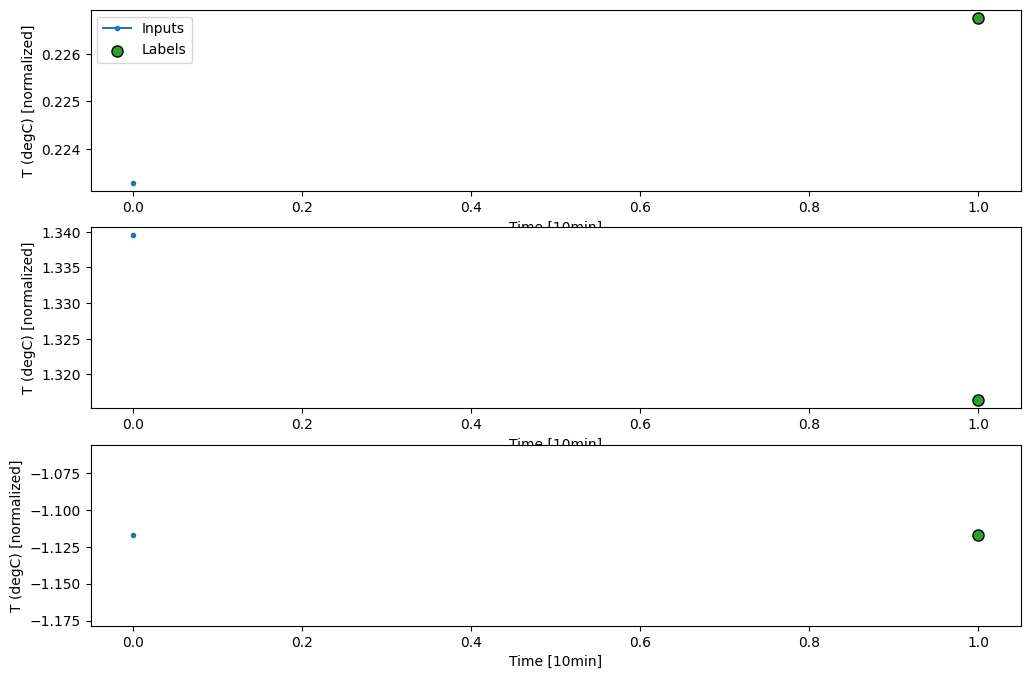

In [109]:
single_step_window.plot()

In [110]:
class Baseline(tf.keras.Model):
    # Baseline model that predicts the temp as not changing
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [111]:
baseline = Baseline(label_index=single_step_window.column_indices['T (degC)'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
performance['baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2629/2629 [==============================] - 6s 2ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


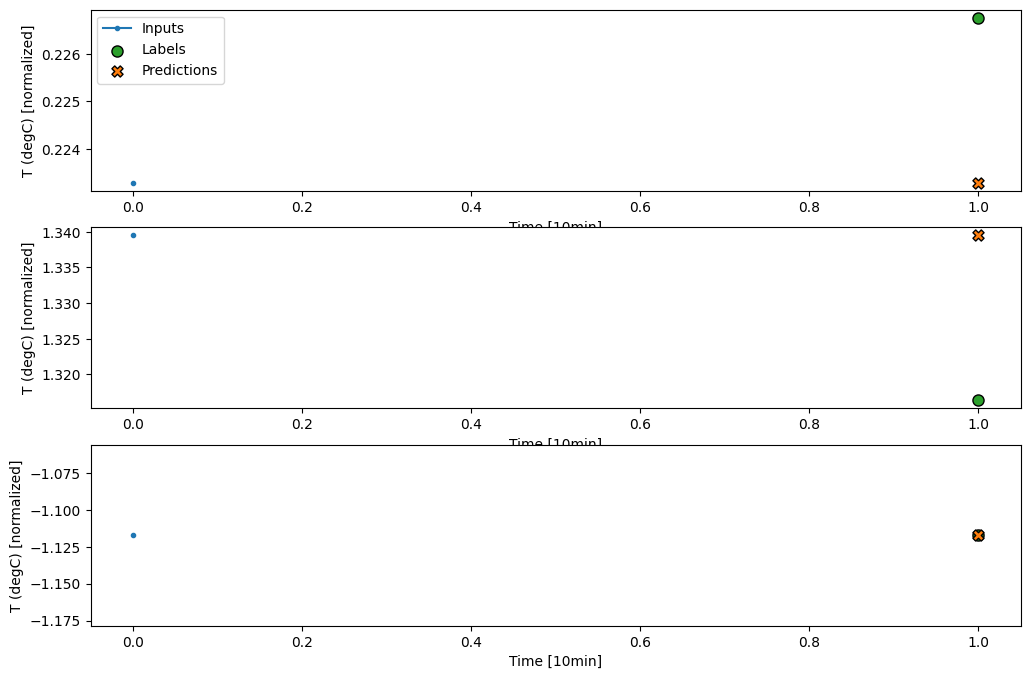

In [112]:
single_step_window.plot(baseline)

In [119]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    label_columns=['T (degC)'])

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label columns names: ['T (degC)']

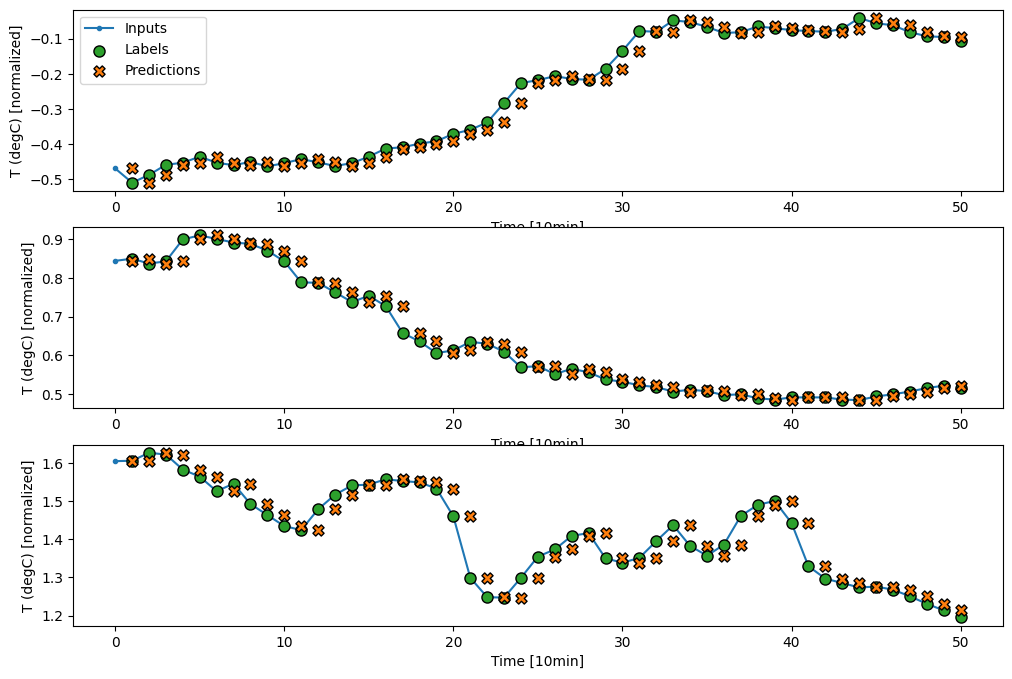

In [120]:
wide_window.plot(baseline)

## Linear Model

In [125]:
MAX_EPOCHS = 20
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
    ])

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(  loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [127]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
9200/9200 [==============================] - 28s 3ms/step - loss: 0.0252 - mean_absolute_error: 0.0599 - val_loss: 6.8867e-04 - val_mean_absolute_error: 0.0175
Epoch 2/20
9200/9200 [==============================] - 27s 3ms/step - loss: 7.4802e-04 - mean_absolute_error: 0.0189 - val_loss: 6.8404e-04 - val_mean_absolute_error: 0.0175
Epoch 3/20
9200/9200 [==============================] - 27s 3ms/step - loss: 7.4379e-04 - mean_absolute_error: 0.0188 - val_loss: 6.9144e-04 - val_mean_absolute_error: 0.0175
Epoch 4/20
1315/1315 [==============================] - 3s 2ms/step - loss: 7.3731e-04 - mean_absolute_error: 0.0184


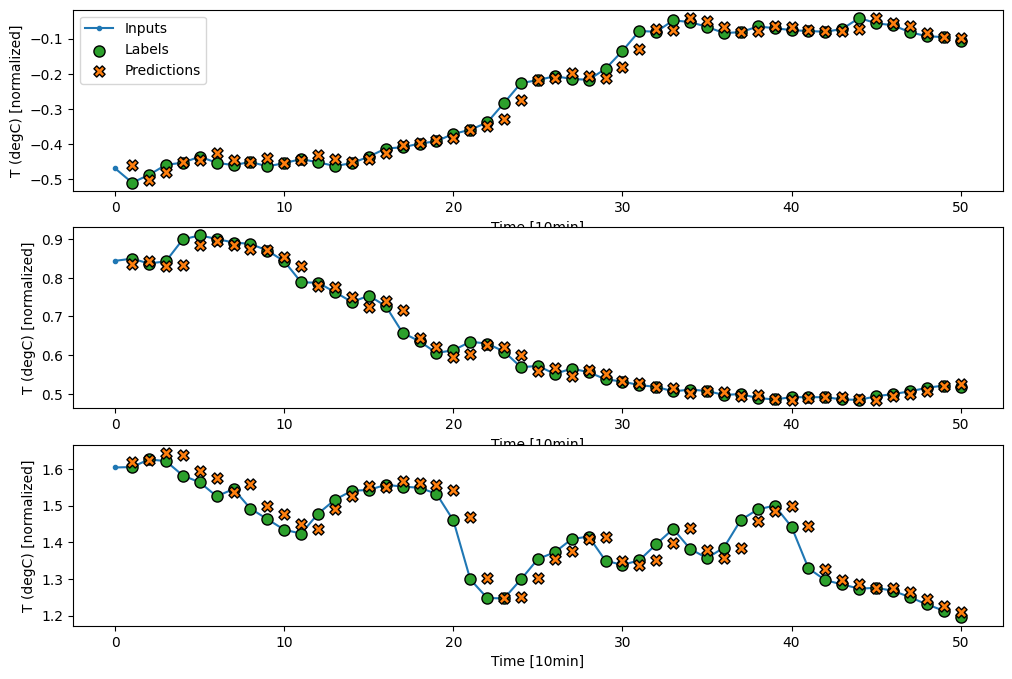

In [128]:
wide_window.plot(linear)

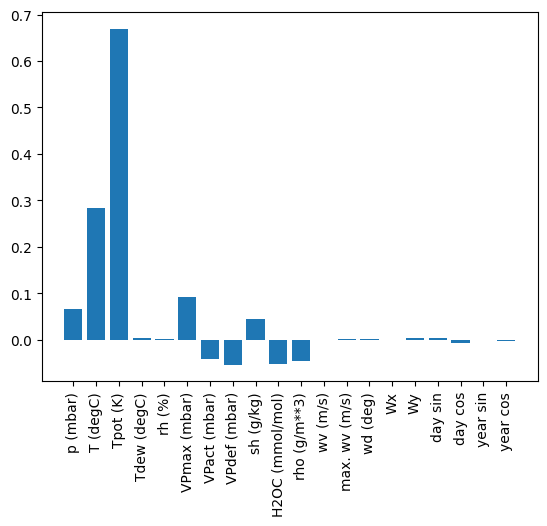

In [130]:
plt.bar(x=range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
ax = plt.gca()

ax.set_xticks(range(len(train_df.columns)))
_ = ax.set_xticklabels(train_df.columns, rotation=90)